In [43]:
# for classification of all files in the folder
# 19.02.2017 -- start

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from EEG_mat_reading import EEG_read, seizureStartEndInd, EEG_part, EEG_data_prep_1, RR_part, RR_data_prep_3

In [44]:
# data_path = 'C:/temp'
#data_path = 'D:/Dropbox/EEG_ECG_DATA/MAT/temp'
#data_path = '/media/antp/DATA/Dropbox/EEG_ECG_DATA/MAT/temp'
data_path = '/media/antp/DATA/Dropbox/EEG_ECG_DATA/MAT/Focal Seizures_processed'
#data_path = '/media/antp/DATA/Dropbox/EEG_ECG_DATA/MAT/Generalized Seizures_processed'
#data_path = '/media/antp/DATA/Dropbox/EEG_ECG_DATA/MAT/temp'

fname = 'focal_seiz_all_samples_'  # name of file to store prepared RR data 

s = os.listdir(data_path)  # list with names of the files in directory

# initial settings
#TT_start = 60  # sec/samples, before seizure
TT_end = 0
RR_type = "RR"
data_type = 's'  # s for samples, t for time
#time_windows = range(60, 180, )
time_windows = [10, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600]  #[10, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300]


In [45]:
#  saving the data to files for further use

for TT_start in time_windows:  # for various window durations
    data = [] # empty list for the data
    targets = []  # empty list for the targets
    print(TT_start)
    flag = 'first'
    for filename in s:  # for all files
        if filename.endswith(".mat"):
            # reading the file with data
            print(filename)
            qwe, xxx = EEG_read(data_path, filename)
            # extration the data from all the files and all seizures
            targ = 1  # target mark for the data, closer to seizure
            (data1, target1) = RR_data_prep_3(qwe, TT_start, TT_end, RR_type, targ, data_type)
            targ = 0  # target mark for the data, more far from the seizure
            (data2, target2) = RR_data_prep_3(qwe, 2 * TT_start, TT_start, RR_type, targ, data_type)
            if data1.any() and data2.any():
                if flag == 'first':
                    data = np.vstack((data1, data2))
                    # targets = np.ravel(np.row_stack((target1, target2)))  # targets = np.ravel(targets)
                    targets = np.append(target1, target2)
                    flag = 'other'
                else:
                    data = np.vstack((data, data1))
                    data = np.vstack((data, data2))
                    targets = np.append(targets, target1)
                    targets = np.append(targets, target2)

        else:
            continue
    
    # saving data to compressed file
    np.savez(fname + str(TT_start), data=data, targets=targets)
    

   

10
bernatskaya-15.mat
bernatskaya1-5.mat
boyko-18.mat
butkevych-15.mat
gudz-5.mat
kaganiuk-15.mat
klavdiev-15.mat
kozubal-13.mat
lekhkodukh-15.mat
mazanichka-15.mat
nesterchuk1-14.mat
nesterchuk2-15.mat
nesterchuk3-15.mat
nesterchuk4-15.mat
podvizhenko-15.mat
polulyah-14-15.mat
reshetnik-15.mat
serdich-14.mat
serdich1-15.mat
stupak-14.mat
tarasov-18.mat
tumareva-14-15.mat
volkogon-15.mat
30
bernatskaya-15.mat
bernatskaya1-5.mat
boyko-18.mat
butkevych-15.mat
gudz-5.mat
kaganiuk-15.mat
klavdiev-15.mat
kozubal-13.mat
lekhkodukh-15.mat
mazanichka-15.mat
nesterchuk1-14.mat
nesterchuk2-15.mat
nesterchuk3-15.mat
nesterchuk4-15.mat
podvizhenko-15.mat
polulyah-14-15.mat
reshetnik-15.mat
serdich-14.mat
serdich1-15.mat
stupak-14.mat
tarasov-18.mat
tumareva-14-15.mat
volkogon-15.mat
60
bernatskaya-15.mat
bernatskaya1-5.mat
boyko-18.mat
butkevych-15.mat
gudz-5.mat
kaganiuk-15.mat
klavdiev-15.mat
kozubal-13.mat
lekhkodukh-15.mat
mazanichka-15.mat
nesterchuk1-14.mat
nesterchuk2-15.mat
nesterchuk3-15.

In [137]:
# reading the data and running the classifier
import timeit
import scipy.signal
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import preprocessing
from statistics import mean, stdev

data_path = '/home/antp/PycharmProjects/untitled'
s = os.listdir(data_path)  # list with names of the files in directory

fname = 'gener_seiz_all_samples_'  # name of file of stored data 
#fname = 'focal_seiz_all_samples_' 

P = 0.8  # ratio for training set
# iterating over all files in the folder, to collect the set of samples
cl_res = [] # empty list for classification results
true_res = []  # empty list for true results
pr=[]
rec=[]
fs=[]
sup=[]
M=[]
sc=[]

for TT_start in time_windows:  # for various window durations
    print('Reading data for ' + str(TT_start) + ' sec. window' )
    filename = fname + str(TT_start)  # forming the filename
    extracted_data = np.load(filename+'.npz')
    data_1 = extracted_data['data']
    targets = extracted_data['targets']
    
       
    # median filtering of the data
    data_2 = scipy.signal.medfilt(data_1, kernel_size=None)
    
    # normalization of data
    data = preprocessing.scale(data_2)
    
    # permutation of the items in the set
    perm = np.random.permutation(data.shape[0])  # preparing the numbers to shuffle
    Data = data[perm, :]  # permuted data
    Targets = targets[perm]  # permuted targets
    train = range(int(round(P * Data.shape[0])))  # numbers of elements in training set
    test = range(int(round(P * Data.shape[0])), data.shape[0])  # numbers of elements in test set

    #########
    # SVM calling and training:
    classifier = svm.SVC(kernel='rbf')  # (kernel='linear')# other kernels: (kernel='poly', degree=3), (kernel='rbf')

    ######
    #  fitting classifiers
    # print("All Targets = ", Targets[train])
    #start_time = timeit.default_timer()
    classifier.fit(Data[train], Targets[train])
    #elapsed = timeit.default_timer()
    #print("Classifier is fit.") #% (elapsed - start_time)#

    # predicting the class in test set:
    cp= classifier.predict(Data[test, :])
    cl_res.append(cp)  # appending the current results of classification
    true_res.append(Targets[test])  # sroting the true labels
    print("Classification results: ", cp)
    print("Correct results: ", Targets[test])
    
    #classification parameters, initial
    #precision, recall, fscore, support = score(Targets[test], cp, average = 'micro')
    
    # flipped
    precision, recall, fscore, support = score(Targets[test], [not i for i in cp], average = 'micro')
    
    pr.append(precision)
    rec.append(recall)
    fs.append(fscore)
    sup.append(support)
    sc.append(classifier.score(Data[test, :], Targets[test]))
    
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    print("Classifier score = ", sc)
 

Reading data for 10 sec. window
Classification results:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Correct results:  [0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1]
precision: 0.5185185185185185
recall: 0.5185185185185185
fscore: 0.5185185185185185
support: None
Classifier score =  [0.48148148148148145]
Reading data for 30 sec. window
Classification results:  [0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Correct results:  [1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1]
precision: 0.7037037037037037
recall: 0.7037037037037037
fscore: 0.7037037037037037
support: None
Classifier score =  [0.48148148148148145, 0.29629629629629628]
Reading data for 60 sec. window
Classification results:  [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
Correct results:  [0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1]
precision: 0.5925925925925926
recall: 0.5925925925925926
fscore: 0.5925925925925926
support: None
Classifier score =  [0.48148148148148145

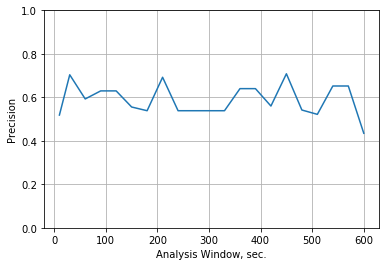

Max. value =  0.708333333333
Mean. value =  0.588814979974
STD. value =  0.07239226297541047


In [138]:
#plt.plot(time_windows, [1-x for x in fs])
plt.plot(time_windows, pr)
plt.ylabel("Precision")
plt.xlabel("Analysis Window, sec.")
plt.ylim((0,1))
plt.grid(True)
plt.show()

print('Max. value = ', max(pr))
print('Mean. value = ', mean(pr))
print('STD. value = ', stdev(pr))



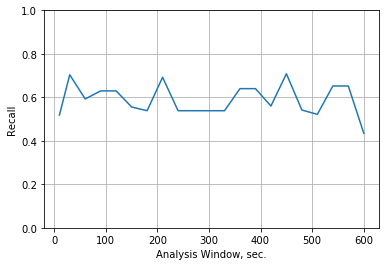

In [139]:
plt.plot(time_windows, rec)
plt.ylabel("Recall")
plt.xlabel("Analysis Window, sec.")
plt.ylim((0,1))
plt.grid(True)
plt.show()